# Genetic Algorithm
In this small experiment I've tried to reconstruct the image of my cat through a Genetic Algorithm.  
The only parameters I could play with were:  
 - POPULATION_SIZE
 - ELITE_SIZE
 - TOURNEMENT_SIZE
 - CROSSOVER_PROBs
 - MUTATION_PROBs
 
**My thoughts**: I think that this is a very difficult task.   
Don't get me wrong, the Genetic Algorithm works well but the task itself is hard.  
Plus the fact that I kept the Algorithm very basic didn't help either :) .   
  
E.g. in this task, we're trying to reconstruct a 450 x 560 gray-scale image.   
Which means that we've (450 * 560)^255, or ... possible combinations :-)  
  
However, I believe that the algorithm did a good enough job :)    
& if the task was a little bit easier e.g. (knapsack problem), then it would kick ass :p 

**Results**: The results are visible in the other notebook!
  
  

# Load libraries & Image

(4509, 5605)


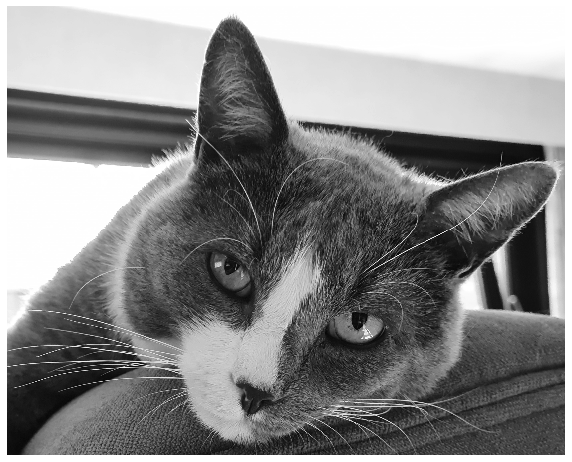

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

def show_image(image):
    # plot the image
    fig = plt.figure(figsize=(10,10))
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    return plt.show()


#-----------------------#
# load the target image #
#-----------------------#
image = cv2.imread('cat_3.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# resize
print(image.shape)
image = cv2.resize(image, (560, 450))

# plot the image
show_image(image)

# Set parameters

In [12]:
TARGET = image.copy()
TARGET_WIDTH =  TARGET.shape[1] 
TARGET_HEIGHT =  TARGET.shape[0] 
TARGET_SIZE = TARGET.shape[0] * TARGET.shape[1]
TARGET_SIZE_MEAN = 1/TARGET_SIZE

POPULATION_SIZE = 50
ELITE_SIZE = 5
TOURNEMENT_SIZE = 6
CROSSOVER_PROB = 67. #% 67% chance that there is a flip, but then there is a 25% chance that nothing happens thus in total it is +/- 50%
CROSSOVER_HORIZONTAL_FLIP_PROB = 50. #%
CROSSOVER_VERTICAL_FLIP_PROB = 50. #%

MUTATION_PROB = 20 # of pixes that can chance%
MUTATION_PIXELS = int(TARGET_SIZE / 100 * MUTATION_PROB)
MUTATION_QUEUE = [0]*5 # if the loss, stays the same, 5 times in a row, reduce the  MUTATION_PROB  value

In [18]:
# Load previous results
logs = pickle.load( open( "logs.p", "rb" ) ) if os.path.isfile('logs.p') else {}

# Init Population

In [4]:
population = pickle.load( open( "population.p", "rb" ) ) if os.path.isfile('population.p') else np.random.randint(low=TARGET.min(), high=TARGET.max(), size=( POPULATION_SIZE, TARGET.shape[0], TARGET.shape[1]), dtype='uint8') 

# Show 1 example

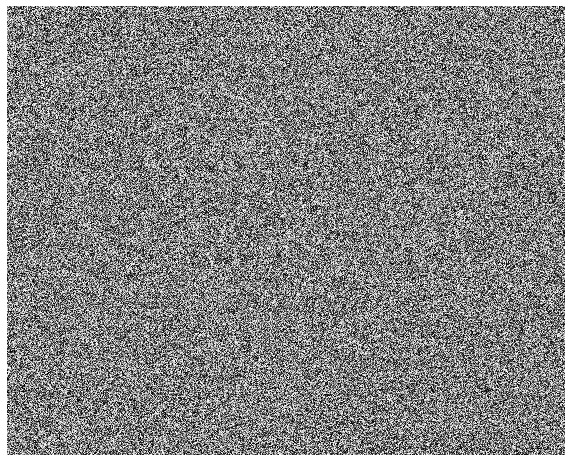

In [4]:
# show random population
show_image(population[0])

# Score each image

In [5]:
def calculate_score(population, target):

    # Mean absolute error 
    loss = np.sum( np.abs(population - target), axis=(1,2)) * TARGET_SIZE_MEAN

    return loss

In [19]:
for i in range(10**12):
    if i <= 291592:
        continue
    #-------#
    # SCORE #
    #-----------------------------------------------------------------#
    # calculate the score of each image and sort our population to it #
    #-----------------------------------------------------------------#
    loss =  calculate_score( population, TARGET )
    population = population[ np.argsort( loss ) ]

    #-------------#
    # Print stats #
    #-------------#
    if i % 1 == 0:
        #print(f'Iteration:{i}\t Best-Score:{(1 - score.min())*100}%\t Mean-Score:{(1 - score.mean())*100}%\t Worse-Score:{(1 - score.max())*100}%\t STD-Score:{score.std()}', end="\r")
        print(f'Iteration:{i}\t Best-Score:{100-(loss.min())/2.55}%\t Mean-Score:{100-(loss.mean())/2.55}%\t Worse-Score:{100-(loss.max())/2.55}%\t STD-Score:{loss.std()}\t MUTATION_PIXELS:{MUTATION_PIXELS}\t ', end="\r")
    if i % 100 == 0:
        logs[i] = population[0].copy()
        pickle.dump( logs, open( "logs.p", "wb" ) )
    if i % 500 == 0:
        pickle.dump( population, open( "population.p", "wb" ) )
        
    #-------------------------#
    # edit the mutation Prob  #
    #-------------------------#
    # add the loss
    MUTATION_QUEUE.append(loss.min())
    # grep the oldest loss
    old_loss = MUTATION_QUEUE.pop(0)
    # of we don't have any improvements, reduce the MUTATION_PIXELS size
    if (old_loss == MUTATION_QUEUE[-1]) and (MUTATION_PIXELS > 2):
        MUTATION_PIXELS = int(MUTATION_PIXELS * 0.9)
        # mutate minimum 24 pixels
        MUTATION_PIXELS = MUTATION_PIXELS if  MUTATION_PIXELS > 2 else 2
    else:
        MUTATION_PIXELS += 1
        
        
    #---------------------#
    # Copy the population #
    #---------------------#
    # copy the the population
    # we'll work with this one and adjust the original one
    tmp_population = population.copy()

    #-------#
    # ELITE #
    #-------#
    # Reserve the first x elite rows

    #--------------------------#
    # Fill in the other values #
    #--------------------------#
    # create an starting index
    index = ELITE_SIZE

    while True:

        #-------------------#
        # Play a Tournement #
        #-------------------#
        # select x random players for tournement 1 & take the best result
        # which is the lowest random value, because our population table was sorted from best (index 0) to worse index (...)
        parent_1 = np.random.randint(low = 0, high = POPULATION_SIZE, size= TOURNEMENT_SIZE).min()

        # select player 2 which should be different then player 1
        parent_2 = None
        while True:
            parent_2 = np.random.randint(low = 0, high = POPULATION_SIZE, size= TOURNEMENT_SIZE).min()
            if parent_1 != parent_2:
                parent_1 = tmp_population[ parent_1 ].copy()
                parent_2 = tmp_population[ parent_2 ].copy()
                break


        #------------#
        # Cross-Over #
        #------------# 
        # x chance that we will perform a cross over
        # | if true, x chance for a vertical flip
        # | if true, y chance for a horizontal flip
        if np.random.uniform()*100 <= CROSSOVER_PROB:

            # x chance for a VERTICAL FLIP
            if np.random.uniform()*100 <= CROSSOVER_VERTICAL_FLIP_PROB:

                # split point
                split_index = np.random.randint(low = 1, high = TARGET.shape[0] - 1) 

                # create a temp copy, because we are ging to overwrite it
                tmp_parent_1 = parent_1[-split_index:, : ].copy()
                parent_1[-split_index:, : ] = parent_2[-split_index:, : ]
                parent_2[-split_index:, : ] = tmp_parent_1

            # x chance for a HORIZONTAL FLIP
            if np.random.uniform()*100 <= CROSSOVER_HORIZONTAL_FLIP_PROB:

                # split point
                split_index = np.random.randint(low = 1, high = TARGET.shape[1] - 1) 

                # create a temp copy, because we are ging to overwrite it
                tmp_parent_1 = parent_1[:, -split_index:].copy()
                parent_1[:, -split_index: ] = parent_2[:, -split_index:]
                parent_2[:, -split_index: ] = tmp_parent_1

        #----------#
        # Mutation #
        #----------#       
        
        # select x pixel coordinates
        # select x pixels at random for both players at once
        mutation_pixels = np.random.randint(TARGET_HEIGHT, size=(MUTATION_PIXELS,4))
        mutation_pixels[:,(1,3)] = np.random.randint(TARGET_WIDTH, size=(MUTATION_PIXELS,2))
        
        # get the value of mutation | create a random pixel value
        mutation_pixel_values = np.random.randint(low = 125, high = 255, size=(MUTATION_PIXELS,2))
        
        # edit the player
        # parent 1
        parent_1[mutation_pixels[:,0], mutation_pixels[:,1]] = np.abs(parent_1[mutation_pixels[:,0], mutation_pixels[:,1]] - mutation_pixel_values[:,0])
               
        # parent 2
        parent_2[mutation_pixels[:,2], mutation_pixels[:,3]] = np.abs(parent_2[mutation_pixels[:,2], mutation_pixels[:,3]] - mutation_pixel_values[:,1])
        
        #-----------------------#
        # update the population #
        #-----------------------#
        # add parent 1
        population[index,: ,: ] = parent_1
        index += 1

        if index >= POPULATION_SIZE: 
            break
        population[index,: ,: ] = parent_2
        index += 1

        # Stop or update the index
        if index >= POPULATION_SIZE:
            break
    

KeyboardInterrupt: 

# Show result

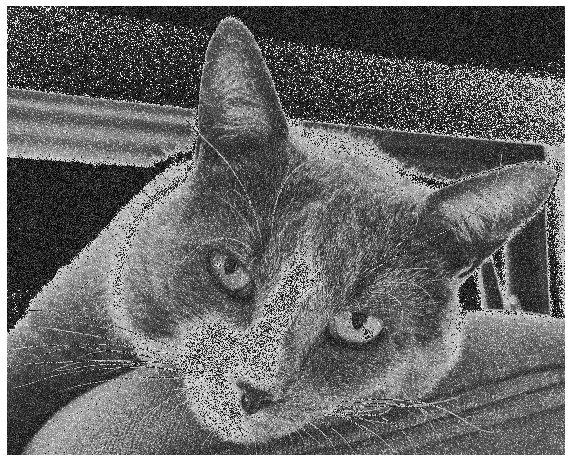

In [20]:
show_image(population[0])